# House Prices Predictions with XGBoost

In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Get Data
Load the data into pandas dataframe

In [22]:
# Load data
df_train = pd.read_csv("data/train.csv").drop("Id", axis=1)
df_test = pd.read_csv("data/test.csv").drop("Id", axis=1)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Prep
* Check dimension of both train and test data
* Visualise the data
* Explore the data
* Handle missing value

In [23]:
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [24]:
missing_values = df_train.isna().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

Most missing value just meant that there is no such feature in that instance.

Features with data entry error:


In [25]:
missing_values_num = missing_values[df_train[missing_values.index].dtypes != "object"]
num_cols = missing_values_num.index.to_list()

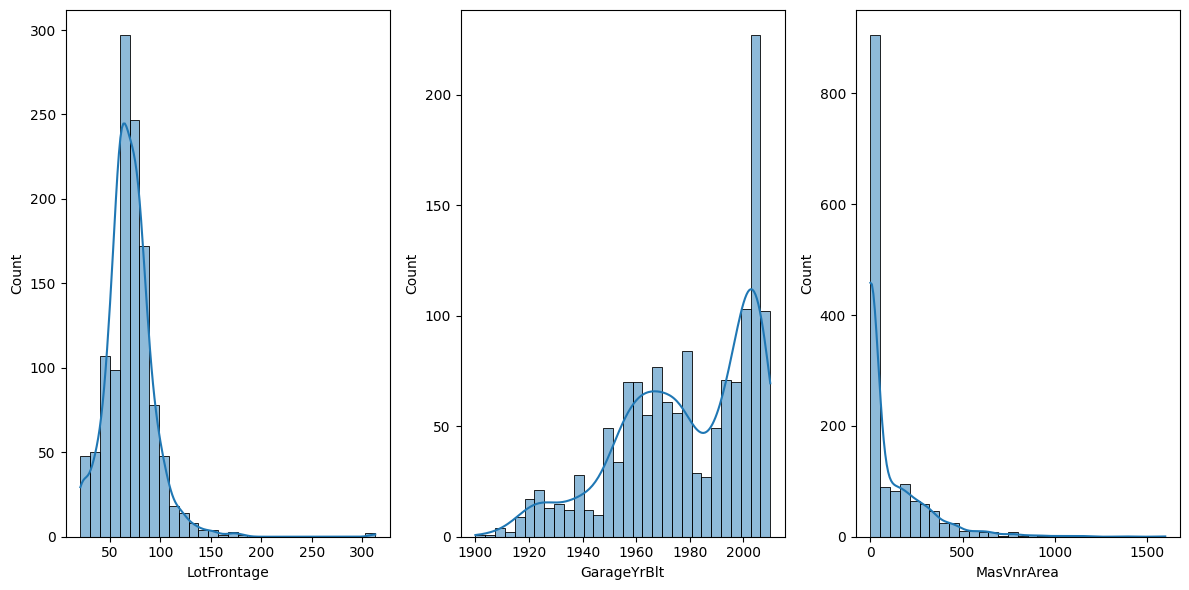

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(df_train['LotFrontage'].dropna(), bins=30, kde=True)

plt.subplot(1, 3, 2)
sns.histplot(df_train['GarageYrBlt'].dropna(), bins=30, kde=True)

plt.subplot(1, 3, 3)
sns.histplot(df_train['MasVnrArea'].dropna(), bins=30, kde=True)

plt.tight_layout()

### House Price Distribution

In [27]:
%pip show xgboost

Name: xgboost
Version: 3.1.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /Users/june/Documents/Projects/House Prices - Advanced Regression Techniques/house-prices-advanced-regression-techniques/.venv/lib/python3.14/site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='SalePrice', ylabel='Count'>

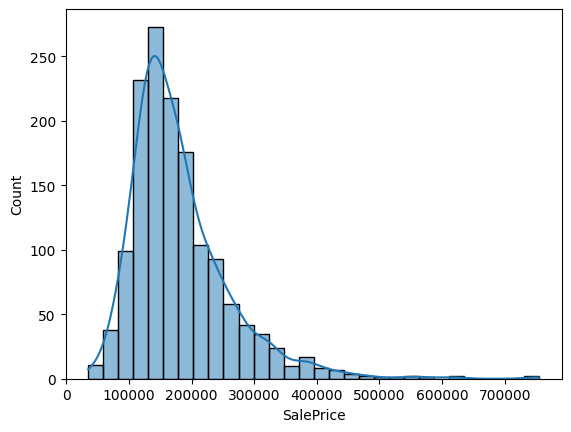

In [28]:
sns.histplot(df_train["SalePrice"], bins=30, kde=True)

### Fill missing data

In [29]:
none_cols = missing_values[df_train[missing_values.index].dtypes == "object"].index.to_list()
none_cols

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'MasVnrType',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtCond',
 'BsmtQual',
 'Electrical']

In [30]:
for df in [df_train, df_test]:
    for col in none_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())


df_train.isna().sum().sum()

np.int64(0)

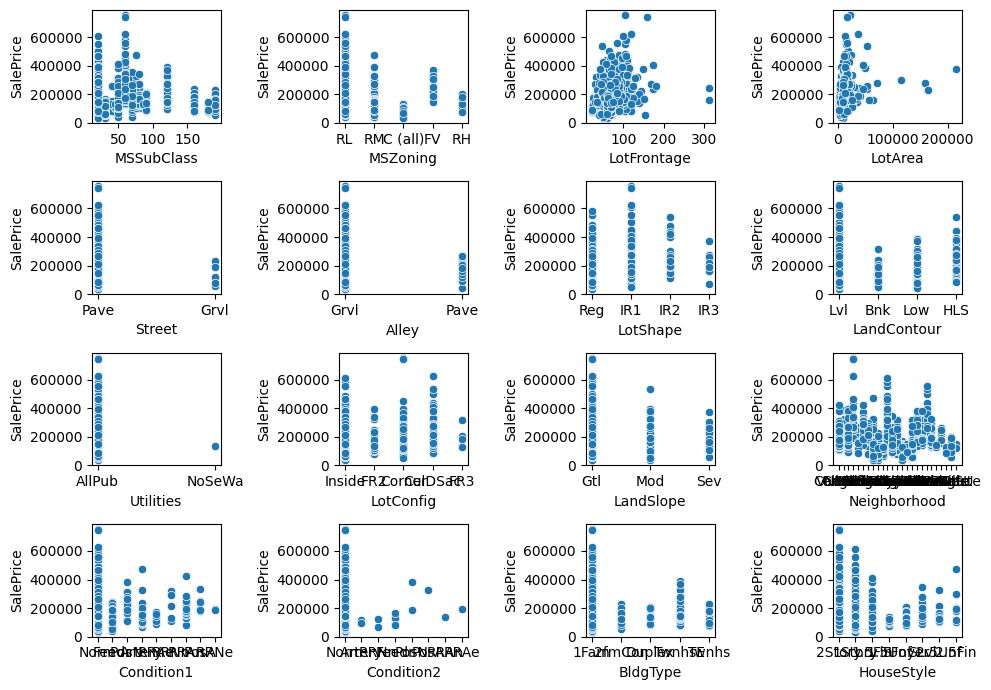

In [31]:
features = df_train.columns[:16]
fig, axes = plt.subplots(4,4, figsize=(10,7))
for ax, col in zip(axes.flatten(), features):
    sns.scatterplot(data=df_train, x=col, y="SalePrice", ax=ax)

plt.tight_layout()
plt.show()

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Data Encoding
obj_cols = df_train.select_dtypes(include=['object']).columns
le = LabelEncoder()
for cols in obj_cols:
    df_train[cols] = le.fit_transform(df_train[cols])
    df_test[cols] = le.fit_transform(df_test[cols])

X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop("SalePrice", axis=1).values,
    df_train["SalePrice"].values,
    test_size=0.2
)

X_eval = df_test.values

feature_names = df_train.drop("SalePrice", axis=1).columns.to_list()
print(feature_names)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

### Define and train the XGBoost Model

In [33]:
#%pip install pandas numpy matplotlib seaborn scikit-learn 

In [34]:
import xgboost as xgb
train_dmatrix = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
test_dmatrix = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)
eval_dmatrix = xgb.DMatrix(X_eval, feature_names=feature_names)

# Documentation for XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse", # root mean square error
    "max_depth": 3, # maximum depth of a tree
    "eta": 0.1, # learning rate
    "sampling_method": "uniform",
    "device": "gpu" if xgb.XGBRegressor().device == "gpu" else "cpu", # send to GPU if available
    "colsample_bytree": 0.5, # subsample ratio of columns when constructing each tree
    "subsample": 0.8,
}  

### Begin training

In [35]:
xgb_model = xgb.train(params, 
                      train_dmatrix, 
                      num_boost_round=1000,
                      verbose_eval=100, # print eval metric every 10 rounds
                      early_stopping_rounds=50,
                      evals=[(train_dmatrix, "train"), (test_dmatrix, "test")],)

[0]	train-rmse:73847.67093	test-rmse:79272.89817
[100]	train-rmse:15187.07804	test-rmse:22555.42729
[158]	train-rmse:12764.94629	test-rmse:22482.90921


#### Save the model

In [36]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
xgb_model.save_model(MODEL_PATH / "xgb_model.json")

In [37]:
loaded_model = xgb.Booster()
loaded_model.load_model(MODEL_PATH / "xgb_model.json")

In [38]:
y_pred = loaded_model.predict(eval_dmatrix)
df_xgb_pred = pd.DataFrame({
    "Id": range(len(df_train)+1,len(df_train)+len(df_test)+1),
    "SalePrice": y_pred,
})
df_xgb_pred.set_index("Id", inplace=True)
PRED_PATH = Path("data/xgb_pred.csv")
df_xgb_pred.to_csv(PRED_PATH)



## Visualize the prediction

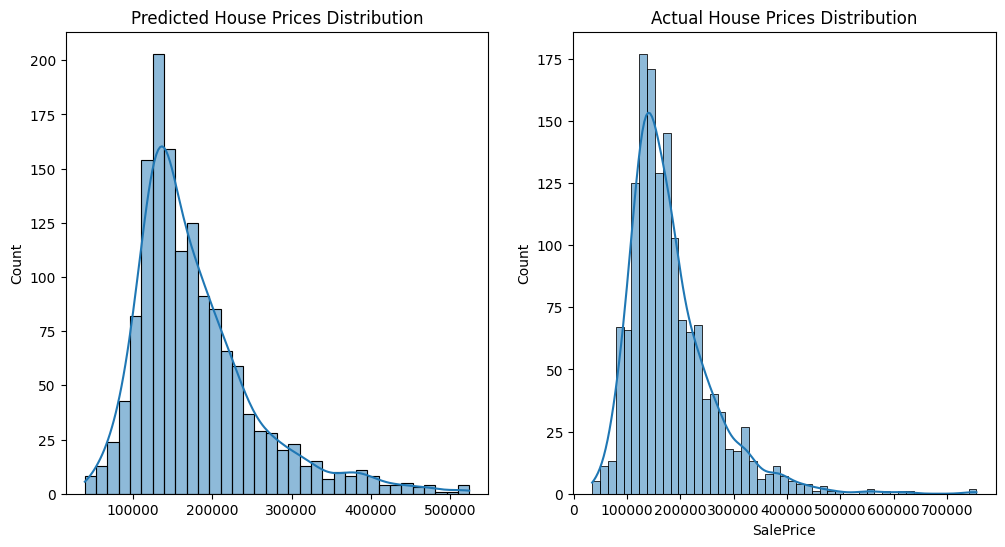

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
ax = sns.histplot(data=y_pred, kde=True).set(title="Predicted House Prices Distribution")
plt.subplot(1,2,2)
ax = sns.histplot(data=df_train["SalePrice"], kde=True).set(title="Actual House Prices Distribution")

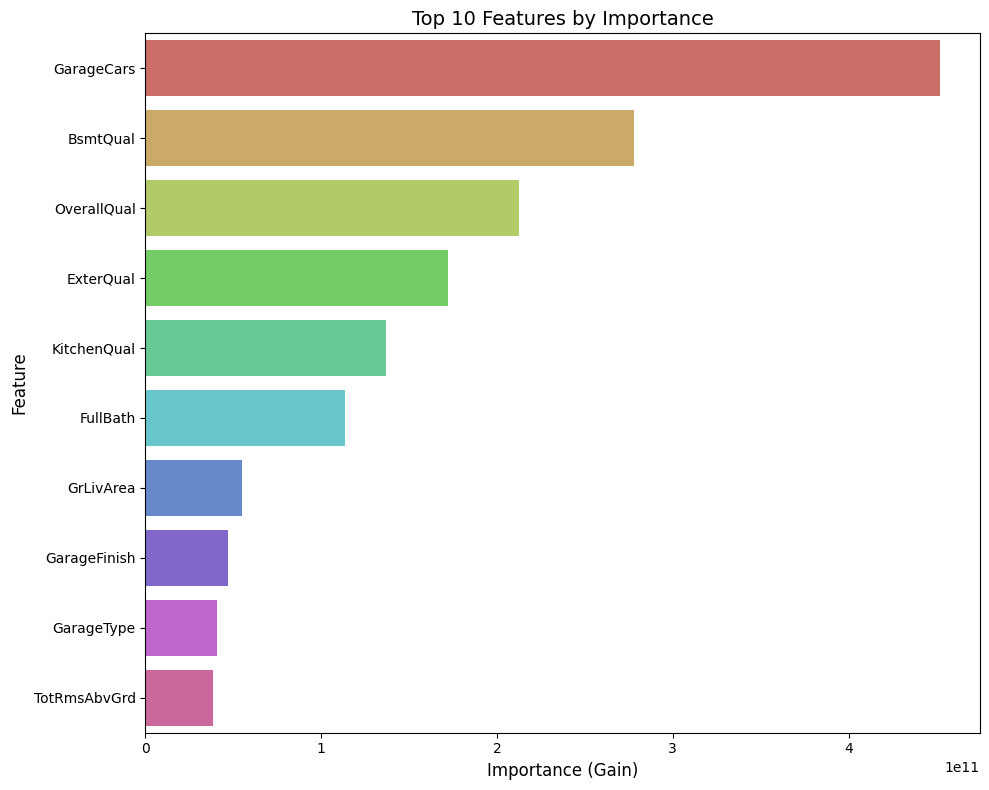

In [40]:
# Feature importance plot
importance = xgb_model.get_score(importance_type='gain')

# Convert to DataFrame and sort
df_importance = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values('Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance',
            y='Feature',
            data=df_importance,
            hue="Feature",
            palette='hls',)
plt.title('Top 10 Features by Importance', fontsize=14)
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()